# <center>MACHINE LEARNING PROJECT <center>
## <center>Face Mask Detection (CNN - MLP - VGG99 - Mobinet)<center>

### **Overview**:
Since Covid-19 is now a Pandemic which a according to a lot of agencies, is still to be under control. In the U.S and many other countries in the world, masks are now mandatory in public including grocery stores, parks, schools etc. We see a need of applications which can detect masks on people entering buildings and also whether they are being socially distanced. This applications could be built in directly to the security camera feeds which is present in almost all buildings.
Places including grocery stores, parks, schools etc. We see a need of applications which can detect masks on people entering buildings and also whether they are being socially distanced. This applications could be built in directly to the security camera feeds which is present in almost all buildings.


In [1]:
##Importing required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
import seaborn as snsor
from tensorflow.keras.preprocessing.image import load_img
import random
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

### **The Data** :

- Dataset of 10k images  divided between masks and no masks. 
- Images contain people across races and ages.
- Training data: 5000 with Mask and 5000 without Mask
- Validation data: 400 with Mask and 400 without Mask
- Testing data: 483 with Mask and 509 without Mask


<img src="Face Mask Dataset/figures/1st.png">

# 1. Haar Cascade for detecting social distancing violations



## Detecting faces using Haar Cascade
- Cascade function is trained from a lot of positive and negative images. 
- It is then used to detect objects in other images.
Can be operated in real time
- Feature extraction and feature evaluation (Rectangular features used)
- With new image representation, their calculation is very fast
- Classifier training and feature selection using AdaBoost
A degenerate decision tree of classifiers is formed


<img src="Face Mask Dataset/figures/haar_cascade_algorithm_flow_chart.png">

## Haar Features
- Haar features - All human faces share some similar properties. These regularities may be matched using Haar features.
- A few properties common to human faces:
The eye region is darker than the upper-cheeks
The nose bridge region is brighter than the eyes.
Composition of properties forming matchable facial features:
- Location and size: eyes, mouth, bridge of nose
- Value: oriented gradients of pixel intensities 



<img src="Face Mask Dataset/figures/haar_features.png">

- The four features matched by this algorithm are then sought in the image of a face
Rectangle features:
- Value = Sum (pixels in black area) - Sum (pixels in white area)
- Three types: two, three, four-rectangles, Viola & Jones used two-rectangle features
- For example: the difference in brightness between the white & black rectangles over a specific area
Each feature is related to a special location in the sub-window


## Feature extraction

<img src="Face Mask Dataset/figures/haar_feature_extraction.png">

## Complex example 

<img src="Face Mask Dataset/figures/haar_feature_complex.png">

## Creating Integral Image for faster calculation
- An image representation called the integral image evaluates rectangular features in constant time, which gives them a considerable speed advantage
- Because each features rectangular area is always adjacent to at least one other rectangle, it's easier to calculate difference between the features
- The integral images at location (x,y) is the sum of the pixels above and to the left of (x,y), inclusive.




## Integral image calculation demo

<img src="Face Mask Dataset/figures/haar_classifer_integral_image_demo.gif">

In [3]:
all_files = []
for dirname, _, filenames in os.walk('Face Mask Dataset/images/'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

In [4]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('Face Mask Dataset/haarcascade_frontalface_default.xml')

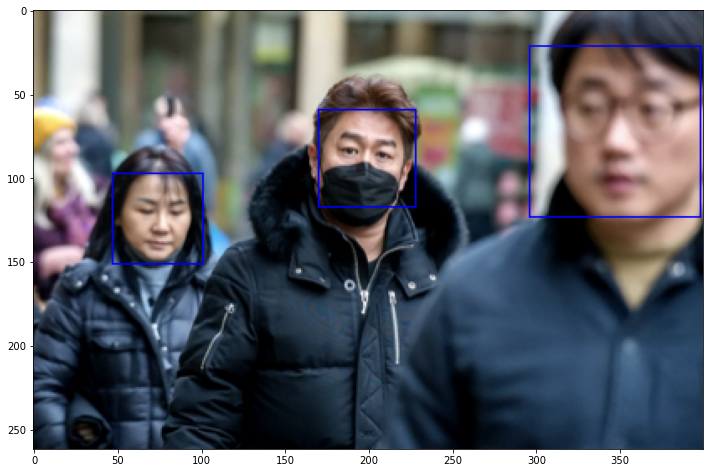

In [5]:
#trying it out on a sample image
img = cv2.imread('Face Mask Dataset/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

Iterating over the coordinates of faces and calculating the distance for each possible pair, if the distance for a particular pair is less than MIN_DISTANCE then the bounding boxes for those faces are colored red. MIN_DISTANCE must be manually initialized in such a way that it corresponds to the minimum allowable distance in real life.

### Model Validation

In [6]:
MIN_DISTANCE = 130

Red box = Not socially distanced

Green box = Socially Distanced

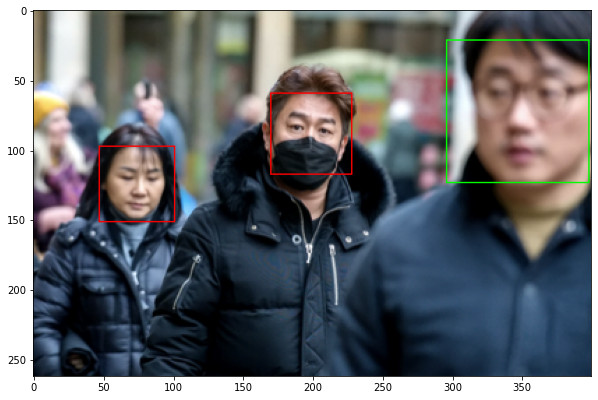

In [7]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
      
else:
    print("No. of faces detected is less than 2")

# 2. Face mask detection  

## 2.1 Multilayer Perceptron (CNN)

Multilayer perceptron is a broad terminology, considered as subset of Deep Neural Networks (DNN).This model introduce you with Multilayer Perceptron which is a class of Feedforward Artificial Neural Networks (ANN). It was the first and one of the simplest Artificial Neural Network. It considered as a simplest model as it only moves in one direction forward (no cycles or loops), From input nodes to hidden layer and an output layer. MLP uses backpropagation for training which anticipates the results to control the process of image transformation.

In [8]:
import pandas as pd
import numpy as np 
import os  
from sklearn.model_selection import train_test_split 

### Preparing Training data


In [9]:
labels = pd.read_csv("Face Mask Dataset/train_labels.csv")   # loading the labels
labels.head()           

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask
2,Image_3.jpg,without_mask
3,Image_4.jpg,without_mask
4,Image_5.jpg,without_mask


### Image file path

In [10]:
file_paths = [[fname, 'Face Mask Dataset/fm_train/' + fname] for fname in labels['filename']]
file_paths

[['Image_1.jpg', 'Face Mask Dataset/fm_train/Image_1.jpg'],
 ['Image_2.jpg', 'Face Mask Dataset/fm_train/Image_2.jpg'],
 ['Image_3.jpg', 'Face Mask Dataset/fm_train/Image_3.jpg'],
 ['Image_4.jpg', 'Face Mask Dataset/fm_train/Image_4.jpg'],
 ['Image_5.jpg', 'Face Mask Dataset/fm_train/Image_5.jpg'],
 ['Image_6.jpg', 'Face Mask Dataset/fm_train/Image_6.jpg'],
 ['Image_7.jpg', 'Face Mask Dataset/fm_train/Image_7.jpg'],
 ['Image_8.jpg', 'Face Mask Dataset/fm_train/Image_8.jpg'],
 ['Image_9.jpg', 'Face Mask Dataset/fm_train/Image_9.jpg'],
 ['Image_10.jpg', 'Face Mask Dataset/fm_train/Image_10.jpg'],
 ['Image_11.jpg', 'Face Mask Dataset/fm_train/Image_11.jpg'],
 ['Image_12.jpg', 'Face Mask Dataset/fm_train/Image_12.jpg'],
 ['Image_13.jpg', 'Face Mask Dataset/fm_train/Image_13.jpg'],
 ['Image_14.jpg', 'Face Mask Dataset/fm_train/Image_14.jpg'],
 ['Image_15.jpg', 'Face Mask Dataset/fm_train/Image_15.jpg'],
 ['Image_16.jpg', 'Face Mask Dataset/fm_train/Image_16.jpg'],
 ['Image_17.jpg', 'Face Ma

#### Number of labels equals number of images

In [11]:
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  11264 matches the number of filenames i.e.  11264


#### Sample image from data

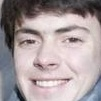

In [12]:
from IPython.display import Image
Image('Face Mask Dataset/fm_train/Image_998.jpg')

#### Converting the file_paths to dataframe

In [13]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,Face Mask Dataset/fm_train/Image_1.jpg
1,Image_2.jpg,Face Mask Dataset/fm_train/Image_2.jpg
2,Image_3.jpg,Face Mask Dataset/fm_train/Image_3.jpg
3,Image_4.jpg,Face Mask Dataset/fm_train/Image_4.jpg
4,Image_5.jpg,Face Mask Dataset/fm_train/Image_5.jpg


#### Combining labels with images

In [14]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()  

,filename,filepaths,label
0,Image_1.jpg,Face Mask Dataset/fm_train/Image_1.jpg,without_mask
1,Image_2.jpg,Face Mask Dataset/fm_train/Image_2.jpg,without_mask
2,Image_3.jpg,Face Mask Dataset/fm_train/Image_3.jpg,without_mask
3,Image_4.jpg,Face Mask Dataset/fm_train/Image_4.jpg,without_mask
4,Image_5.jpg,Face Mask Dataset/fm_train/Image_5.jpg,without_mask


### Data Preprocessing

In [15]:
import cv2
data = []     
image_size = 100      # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):

    img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale

    new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array

    # encoding the labels. with_mask = 1 and without_mask = 0
    if train_data['label'][i] == 'with_mask':
        data.append([new_img_array, 1])
    else:
        data.append([new_img_array, 0])

In [16]:
# image pixels of a image
data[0]

[array([[119, 119, 119, ...,  36,  44,  48],
        [126, 127, 127, ...,  43,  36,  45],
        [132, 132, 133, ...,  42,  35,  41],
        ...,
        [129, 117, 140, ...,  75,  51,  25],
        [119, 117, 136, ...,  79,  59,  31],
        [118, 129, 137, ...,  83,  65,  37]], dtype=uint8),
 0]

In [17]:
data = np.array(data)
data[0][0].shape

(100, 100)

#### Shuffling

Images needed to shuffle as first half has data with mask and second half has without mask data. Model needs to train with both the categories in order to detect them.

In [18]:
np.random.shuffle(data)

In [19]:
import matplotlib.pyplot as plt

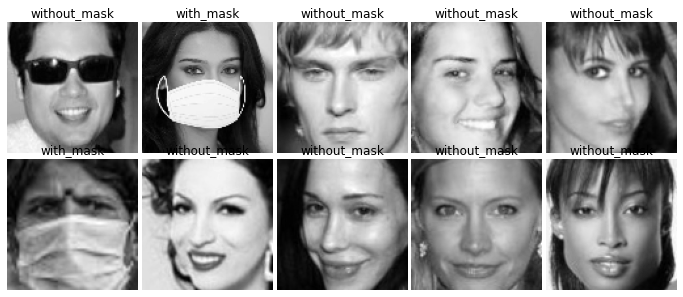

In [20]:
#view the images
num_rows, num_cols = 2, 5
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
      
        image_index = r * 100 + c
        ax[r,c].axis("off")
        ax[r,c].imshow( data[image_index][0], cmap='gray')
        if data[image_index][1] == 0:
            ax[r,c].set_title('without_mask')
        else:
            ax[r,c].set_title('with_mask')
plt.show()
plt.close()

### Separating image and labels

In [21]:
x = []
y = []
for image in data:
    x.append(image[0])
    y.append(image[1])

# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)

In [22]:
np.unique(y, return_counts=True)

(array([0, 1]), array([5632, 5632]))

In [23]:
x = x / 255

# Why divided by 255?
# The pixel value lie in the range 0 - 255 representing the RGB (Red Green Blue) value.

In [24]:
# spliting the data
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.3, random_state = 42)

### Training Model

- Fully connected layers uses softmax activation function in output layer
- Every node in previous layer connected to every node in next layer (I/P -> Hidden -> O/P)
- Convolution and Pooling model used to identify high level image features 
- Based on features MLP model classifies the image using training dataset


In [25]:
import warnings


In [26]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(100, 100)),    # flattening the image
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size = 20)

Epoch 1/10
395/395 [==============================] - 1s 2ms/step - loss: 0.7028 - accuracy: 0.6741
Epoch 2/10
395/395 [==============================] - 1s 2ms/step - loss: 0.4171 - accuracy: 0.8193
Epoch 3/10
395/395 [==============================] - 1s 2ms/step - loss: 0.3598 - accuracy: 0.8435
Epoch 4/10
395/395 [==============================] - 1s 2ms/step - loss: 0.3278 - accuracy: 0.8576
Epoch 5/10
395/395 [==============================] - 1s 2ms/step - loss: 0.3103 - accuracy: 0.8723
Epoch 6/10
395/395 [==============================] - 1s 2ms/step - loss: 0.2956 - accuracy: 0.8734
Epoch 7/10
395/395 [==============================] - 1s 3ms/step - loss: 0.2784 - accuracy: 0.8838
Epoch 8/10
395/395 [==============================] - 1s 3ms/step - loss: 0.3067 - accuracy: 0.8656
Epoch 9/10
395/395 [==============================] - 1s 3ms/step - loss: 0.2837 - accuracy: 0.8789
Epoch 10/10
395/395 [==============================] - 1s 3ms/step - loss: 0.2580 - accuracy: 0.8873

### MLP Model Validation

In [27]:
model.evaluate(X_val, y_val)

106/106 [==============================] - 0s 1ms/step - loss: 0.2815 - accuracy: 0.8781


[0.2815481424331665, 0.8781065344810486]

- A two layer backpropagation network with hidden nodes proven to be universal approximator
MLP do not make any assumptions regarding probability 
- Underlying probability density function
- Any probabilistic information about pattern classes 
Required decision function yield directly via training 
- Preferred techniques for gesture recognition 


## 2.2 VGG19

The VGGNet architecture is based on CNN. It is said to one of the best architectures in use today

The VGG19 architecture – it consists of a series of Convolution layers followed by a max pooling layer

In the end there is a fully connected Neural Net with ReLU and a soft max activation which can have up to 1000 classes

<img src="Face Mask Dataset/figures/VGG Arch 1.png">

### The difference in the architectures of VGG16 and VGG19

<img src="Face Mask Dataset/figures/VGG 16 VGG 19.png">

The only difference is the depth to which is are built are different. Some classification problems may perform better with VGG16 while other may perform better with VGG19

In [28]:
#Load train and test set
train_dir = './Face Mask Dataset/Train'
test_dir = './Face Mask Dataset/Test'
val_dir = './Face Mask Dataset/Validation'

In [29]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


For building the model – 

**weights**: ImageNet (weights which have been annotated through Image Net have been used. ImageNet is a dataset where images are pre-annotated)

**input_shape**: 128x128 (3 denotes RGB) 

**include_top**: False
input image is resized and the output classes will be 2 (1000 is default)

**activation**: sigmoid (only 2 classes)

In [30]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [31]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [32]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

Epoch 1/20
9/9 [==============================] - 20s 2s/step - loss: 0.6771 - accuracy: 0.6314
Epoch 2/20
9/9 [==============================] - 20s 2s/step - loss: 0.3053 - accuracy: 0.8543
Epoch 3/20
9/9 [==============================] - 21s 2s/step - loss: 0.1789 - accuracy: 0.9349
Epoch 4/20
9/9 [==============================] - 21s 2s/step - loss: 0.1075 - accuracy: 0.9741
Epoch 5/20
9/9 [==============================] - 22s 2s/step - loss: 0.0890 - accuracy: 0.9722
Epoch 6/20
9/9 [==============================] - 21s 2s/step - loss: 0.0685 - accuracy: 0.9805
Epoch 7/20
9/9 [==============================] - 21s 2s/step - loss: 0.0607 - accuracy: 0.9824
Epoch 8/20
9/9 [==============================] - 21s 2s/step - loss: 0.0941 - accuracy: 0.9426
Epoch 9/20
9/9 [==============================] - 20s 2s/step - loss: 0.0798 - accuracy: 0.9933
Epoch 10/20
9/9 [==============================] - 21s 2s/step - loss: 0.0777 - accuracy: 0.9798
Epoch 11/20
9/9 [======================

In [33]:
model.evaluate_generator(test_generator)

[0.04233855754137039, 0.9858871102333069]

### Model Validation

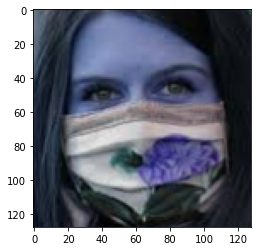

In [34]:
sample_mask_img1 = cv2.imread('./Face Mask Dataset/Test/WithMask/187.png')
sample_mask_img1 = cv2.resize(sample_mask_img1,(128,128))
plt.imshow(sample_mask_img1)
sample_mask_img1 = np.reshape(sample_mask_img1,[1,128,128,3])
sample_mask_img1 = sample_mask_img1/255.0

In [35]:
model.predict(sample_mask_img1)

array([[0.98006535, 0.07107526]], dtype=float32)

Here we can see that there is a 0.71 probability of the person wearing a mask

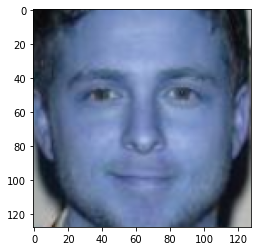

In [36]:
sample_mask_img2 = cv2.imread('./Face Mask Dataset/Test/WithoutMask/147.png')
sample_mask_img2 = cv2.resize(sample_mask_img2,(128,128))
plt.imshow(sample_mask_img2)
sample_mask_img2 = np.reshape(sample_mask_img2,[1,128,128,3])
sample_mask_img2 = sample_mask_img2/255.0

In [37]:
model.predict(sample_mask_img2)

array([[0.07868743, 0.9842355 ]], dtype=float32)

Here we can see that there is a 0.97 probability that the person is not wearing a mask

## 2.3 MobileNet

- MobileNet is a CNN architecture model for Image Classification and Mobile Vision.
- MobileNet requires very less computation power to run or apply transfer learning to.
- perfect fit for Mobile devices,embedded systems and computers without GPU or low computational efficiency
- uses depth wise separable convolutions to build light weight deep neural networks.


The full MobileNet V2 architecture, then, consists of 17" building blocks" in a row. This is followed by a regular 1×1 convolution, a global average pooling layer, and a classification layer
MACs are multiply-accumulate operations, which measure how many calculations are needed to perform inference on a single 224×224 RGB image. V2 requires approx 300 such calculations.
This model offers us Reduced network size ,Reduced number of parameters ,Faster in performance and are useful for mobile applications.,Small, low-latency convolutional neural network.


<img src="Face Mask Dataset/figures/mn1.png">

<img src="Face Mask Dataset/figures/mn2.png">

In [38]:
train_dir = "Face Mask Dataset/Train/"
test_dir = "Face Mask Dataset/Test/"
val_dir = './Face Mask Dataset/Validation'

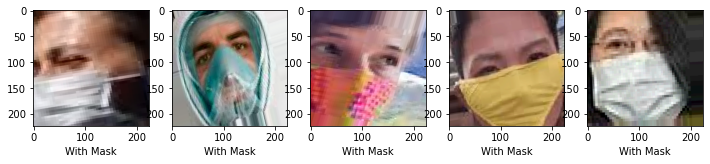

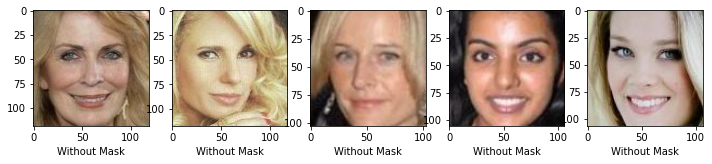

In [39]:
#with Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(train_dir+"WithMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"WithMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(train_dir+"WithoutMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"WithoutMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

In [40]:
height = 150
width=150
train_datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.2,shear_range = 0.2,zoom_range=0.2,horizontal_flip=True)
train = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset = "training")

valid_datagen = ImageDataGenerator(rescale=1.0/255)

valid = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset="validation")

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [41]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(150,150,3))

9412608/9406464 [==============================] - 1s 0us/step


In [42]:
for layer in mobilenet.layers:
    layer.trainable = False

In [43]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 64002     
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("moblenet_facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [47]:
history = model.fit_generator(generator=train,steps_per_epoch=len(train)// 32,validation_data=valid,
                             validation_steps = len(valid)//32,callbacks=[checkpoint,earlystop],epochs=15)

Epoch 1/15
7/7 [==============================] - 6s 575ms/step - loss: 4.8479 - accuracy: 0.6541 - val_loss: 1.0105 - val_accuracy: 0.8438

Epoch 00001: val_accuracy improved from -inf to 0.84375, saving model to moblenet_facemask.h5
Epoch 2/15
7/7 [==============================] - 3s 445ms/step - loss: 0.4651 - accuracy: 0.9399 - val_loss: 1.9744e-07 - val_accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.84375 to 1.00000, saving model to moblenet_facemask.h5
Epoch 3/15
7/7 [==============================] - 3s 386ms/step - loss: 0.4585 - accuracy: 0.9741 - val_loss: 0.5303 - val_accuracy: 0.9688

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/15
7/7 [==============================] - 3s 438ms/step - loss: 0.1053 - accuracy: 0.9884 - val_loss: 0.7955 - val_accuracy: 0.9688

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/15
7/7 [==============================] - 3s 446ms/step - loss: 0.0615 - accuracy: 0.9947 - val_loss: 8.9903e-05 - val_accu

In [48]:
model.evaluate_generator(valid)

[0.22745804488658905, 0.9714999794960022]

In [49]:
model.save("face_mask.h5")
pred = model.predict_classes(valid)
pred[:15]

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

### Running Haar cascade to detect Face and mobileNet to detect Mask

In [75]:
def mobileNet_mask_id(image_name):
    
    mask = "Face Mask Dataset/Validation"
    plt.figure(figsize=(8,7))
    label = {0:"With Mask",1:"Without Mask"}
    color_label = {0: (0,255,0),1 : (0,0,255)}
    cascade = cv2.CascadeClassifier("Face Mask Dataset/haarcascade_frontalface_default.xml")
    count = 0
    i = "Face Mask Dataset/Validation/" + image_name

    frame =cv2.imread(i)
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = cascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        face_image = frame[y:y+h,x:x+w]
        resize_img  = cv2.resize(face_image,(150,150))
        normalized = resize_img/255.0
        reshape = np.reshape(normalized,(1,150,150,3))
        reshape = np.vstack([reshape])
        result = model.predict_classes(reshape)

        if result == 0:
            cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[0],1)
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            plt.imshow(frame)
        elif result == 1:
            cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[1],1)
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            plt.imshow(frame)
        plt.imshow(frame)
    plt.show()
    cv2.destroyAllWindows()

### Model Validation

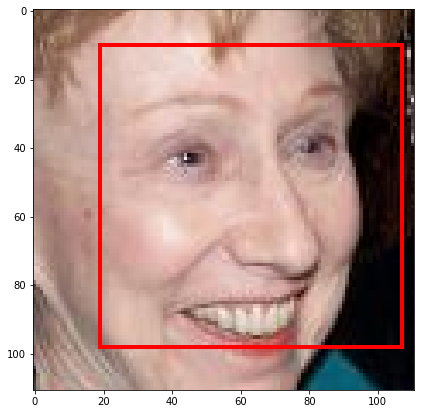

In [76]:
mobileNet_mask_id('WithoutMask/431.png')

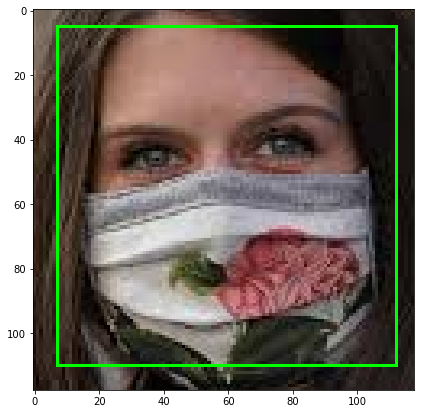

In [77]:
mobileNet_mask_id('WithMask/431.png')